# Confidence Regions for Multiple Outcomes, Effect Modifiers, and Other Multiple Comparisons

Paul Zivich

## Setup

In [1]:
import numpy as np
import pandas as pd
from formulaic import model_matrix
from scipy.stats import norm, chi2
import matplotlib.pyplot as plt
from delicatessen import MEstimator
from delicatessen.estimating_equations import ee_regression
from delicatessen.utilities import inverse_logit, regression_predictions

### Loading Data

In [2]:
d = pd.read_csv("data/actg.csv")

### Helper Functions

In [3]:
def confidence_bands(theta, covariance, alpha=0.05, method='supt', n_draws=100000, seed=None, print_cv=False):
    # Pre-processing inputs
    theta = np.asarray(theta)
    covariance = np.asarray(covariance)
    stderr = np.diag(covariance) ** 0.5

    # Approximate new critical value c_alpha
    rng = np.random.default_rng(seed=seed)
    k = len(theta)
    if method.lower() in ['supt', 'sup-t']:
        mvn = rng.multivariate_normal([0., ] * k, cov=covariance, size=n_draws)
        scaled_mvn = np.abs(mvn / stderr)
        ts = np.max(scaled_mvn, axis=1)
        critical_value = np.percentile(ts, q=(1 - alpha) * 100)
    elif method.lower() == 'bonferroni':
        critical_value = norm.ppf(1 - alpha / (2 * k), loc=0, scale=1)
    else:
        raise ValueError("The confidence band method '" + str(method) + "' was specified, but only the following "
                         "methods are supported: 'supt', 'bonferroni'.")

    if print_cv:
        print("Critical Value:", critical_value)
    
    # Computing the corresponding confidence bands
    conf_bands = np.asarray([theta - critical_value * stderr,
                             theta + critical_value * stderr])

    # Returning confidence bands
    return conf_bands.T


def confidence_ellipse(theta, covariance, alpha=0.05):
    # Pre-processing inputs
    theta = np.asarray(theta)
    covariance = np.asarray(covariance)
    p = len(theta)
    if p > 2:
        raise ValueError("This function only works for 2D parameter vectors")
    c = chi2.ppf(1 - alpha, df=p)

    # Eigen-Decomposition of covariance matrix 
    vals, vecs = np.linalg.eigh(covariance)

    # Making a unit-circle
    t = np.linspace(0, 2 * np.pi, 200)
    circle = np.vstack((np.cos(t), np.sin(t)))  # 2 x N

    # Rescale circle into ellipse
    scale = np.sqrt(c * vals)
    ellipse = (vecs @ np.diag(scale)) @ circle

    # Shifting ellipse from [0,0] to theta
    ellipse = ellipse.T + theta

    # Returning confidence ellipse
    return ellipse

## Case Study 1: Multiple Outcomes

In [4]:
a = np.asarray(d['treat'])
y1 = np.asarray(d['cd4_20wk'])
y2 = np.asarray(d['cd8_20wk'])
n = a.shape[0]

In [5]:
def estfunc(theta):
    psi_1, psi_2 = theta[0], theta[1]
    mu_1, mu_0 = theta[2], theta[3]
    om_1, om_0 = theta[4], theta[5]

    # Estimating functions
    ef_psi1 = np.ones(n)*(mu_1 - mu_0) - theta[0]
    ef_psi2 = np.ones(n)*(om_1 - om_0) - theta[1]
    ef_mu1 = a * (y1 - mu_1)
    ef_mu0 = (1-a) * (y1 - mu_0)
    ef_om1 = a * (y2 - om_1)
    ef_om0 = (1-a) * (y2 - om_0)

    # Returning stacked estimating functions
    return np.vstack([ef_psi1, ef_psi2, ef_mu1, ef_mu0, ef_om1, ef_om0])

In [6]:
estr = MEstimator(estfunc, init=[0, 0, 300, 300, 900, 900])
estr.estimate()

psi = estr.theta[:2]
v_psi = estr.variance[:2, :2]

In [7]:
print("Params:", psi)
print("Covariance:")
v_psi

Params: [51.43642807  6.51611582]
Covariance:


array([[ 52.75897985,  39.15336924],
       [ 39.15336924, 531.72306418]])

### Confidence Intervals

In [8]:
ci = estr.confidence_intervals()
print("95% Confidence Intervals")
print(ci[:2, :])

95% Confidence Intervals
[[ 37.20015579  65.67270035]
 [-38.67893098  51.71116261]]


### Confidence Bands - Bonferroni

In [9]:
cb_b = confidence_bands(psi, v_psi, method='bonferroni', print_cv=True)
print("95% Confidence Bands -- Bonferroni")
print(cb_b[:2, :])

Critical Value: 2.241402727604947
95% Confidence Bands -- Bonferroni
[[ 35.15591487  67.71694127]
 [-45.16866103  58.20089266]]


### Confidence Bands - sup-t

In [10]:
cb_s = confidence_bands(psi, v_psi, method='supt', n_draws=1000000, seed=3281851, print_cv=True)
print("95% Confidence Bands -- sup-t")
print(cb_s[:2, :])

Critical Value: 2.228891011826748
95% Confidence Bands -- sup-t
[[ 35.24679419  67.62606195]
 [-44.88015186  57.91238349]]


### Confidence Ellipse

In [11]:
ce = confidence_ellipse(psi, v_psi)
# Not printing results, since not interpretable

### Confidence Regions Plot

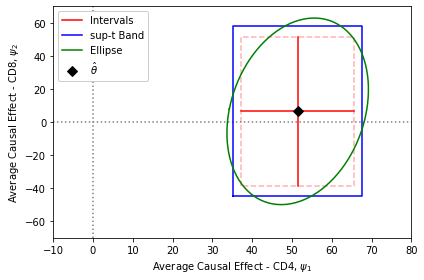

In [12]:
# References lines for the null
plt.axhline(linestyle=':', color='gray')
plt.axvline(linestyle=':', color='gray')

# Plotting Implied Confidence Interval Rectangle
plt.plot([ci[0, 0], ci[0, 0], ci[0, 1], ci[0, 1], ci[0, 0]],
         [ci[1, 0], ci[1, 1], ci[1, 1], ci[1, 0], ci[1, 0]],
         '--', color='red', alpha=0.3)
# Plotting Confidence Intervals
plt.plot([ci[0, 0], ci[0, 1]],
         [psi[1], psi[1]],
         '-', color='red', label='Intervals')
plt.plot([psi[0], psi[0]],
         [ci[1, 0], ci[1, 1]],
         '-', color='red')

# Plotting Confidence Bands
plt.plot([cb_s[0, 0], cb_s[0, 0], cb_s[0, 1], cb_s[0, 1], cb_s[0, 0]],
         [cb_s[1, 0], cb_s[1, 1], cb_s[1, 1], cb_s[1, 0], cb_s[1, 0]],
         color='blue', label='sup-t Band')

# Plotting Confidence Ellipse
plt.plot(ce[:, 0], ce[:, 1], color='green', label='Ellipse')

# Estimate Parameters
plt.plot([psi[0], ], [psi[1], ], 'D', color='k', markersize=7, label=r'$\hat{\theta}$')

# Plot Formatting
plt.ylim([-70, 70])
plt.ylabel(r"Average Causal Effect - CD8, $\psi_2$")
plt.xlim([-10, 80])
plt.xlabel(r"Average Causal Effect - CD4, $\psi_1$")
plt.legend(loc='upper left', framealpha=1.)
plt.tight_layout()

## Case Study 2: Effect Modification - Binary

In [13]:
msm = model_matrix("treat + male + treat:male", data=d)
a = np.asarray(d['treat'])
y = np.asarray(d['cd4_20wk'])

In [14]:
def estfunc(theta):
    # Estimating functions
    ef_msm = ee_regression(theta=theta, X=msm, y=y, model='linear')

    # Returning stacked estimating functions
    return ef_msm

In [15]:
estr = MEstimator(estfunc, init=[300, 0, 0, 0])
estr.estimate()

psi = estr.theta
v_psi = estr.variance

In [16]:
print("Params:", psi)

Params: [356.82       -25.46814815  42.07265537  11.84591856]


### Confidence Intervals

In [17]:
ci = estr.confidence_intervals()

### Confidence Bands - Bonferroni

In [18]:
cb_b = confidence_bands(psi, v_psi, method='bonferroni')

### Confidence Bands - sup-t

In [19]:
cb_s = confidence_bands(psi, v_psi, method='supt', seed=9281851)

In [20]:
r = pd.DataFrame()
r['Names'] = list(msm.columns)
r['Estimate'] = np.round(psi, 1)
r['Interval'] = [np.array2string(x) for x in np.round(ci, 1)]
r['Bonferroni'] = [np.array2string(x) for x in np.round(cb_b, 1)]
r['sup-t'] = [np.array2string(x) for x in np.round(cb_s, 1)]
r['Width-I'] = [np.round(x[1] - x[0], 1) for x in ci]
r['Width-B'] = [np.round(x[1] - x[0], 1) for x in cb_b]
r['Width-S'] = [np.round(x[1] - x[0], 1) for x in cb_s]
r.T

,0,1,2,3
Names,Intercept,male,treat,male:treat
Estimate,356.8,-25.5,42.1,11.8
Interval,[328.8 384.8],[-55.9 5. ],[ 6.1 78. ],[-27.3 51. ]
Bonferroni,[321.1 392.5],[-64.3 13.4],[-3.7 87.9],[-38. 61.7]
sup-t,[324.1 389.6],[-61.1 10.2],[ 0. 84.1],[-33.9 57.6]
Width-I,56.0,60.9,71.9,78.2
Width-B,71.4,77.7,91.6,99.7
Width-S,65.5,71.3,84.1,91.5


In [21]:
areas = r[['Width-I', 'Width-B', 'Width-S']].prod(axis=0).round(0)
areas / areas.iloc[-1]

Width-I    0.533572
Width-B    1.409814
Width-S    1.000000
dtype: float64

## Case Study 3: Effect Modification - Continuous

In [22]:
msm = model_matrix("treat + cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3 "
                   "+ treat:(cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3)", data=d)
a = np.asarray(d['treat'])
y = np.asarray(d['cd4_20wk'])

In [23]:
def estfunc(theta):
    # Estimating functions
    ef_msm = ee_regression(theta=theta, X=msm, y=y, model='linear')

    # Returning stacked estimating functions
    return ef_msm

In [24]:
inits = [300, ] + [0, ]*(msm.shape[1] - 1)
estr = MEstimator(estfunc, init=inits)
estr.estimate(deriv_method='capprox')

psi = estr.theta
v_psi = estr.variance

### Grid - 50 points

In [25]:
# Loading pre-processed data set for predicting outcomes
dp = pd.read_csv("data/actg_predict_g50.csv")
Xp = model_matrix("treat + cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3 "
                  "+ treat:(cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3)", data=dp)
xvals_50 = np.asarray(dp['cd4_0wk'])

# Generating predictions
y_hat = regression_predictions(X=Xp, theta=psi, covariance=v_psi)
y_50 = y_hat[:, 0]
var = y_hat[:, 1]

# Covariance matrix for predictions
cov_p = Xp @ v_psi @ Xp.T

#### Confidence Intervals

In [26]:
ci_50 = y_hat[:, 2:]

#### Confidence Bands - Bonferroni

In [27]:
cb_b_50 = confidence_bands(y_50, covariance=cov_p, method='bonferroni', 
                           print_cv=True)

Critical Value: 3.2905267314919255


#### Confidence Bands - sup-t

In [28]:
cb_s_50 = confidence_bands(y_50, covariance=cov_p, method='supt', 
                           seed=9209341, print_cv=True)

Critical Value: 2.80067590197671


### Grid - 1000 points

In [29]:
# Loading pre-processed data set for predicting outcomes
dp = pd.read_csv("data/actg_predict_g1000.csv")
Xp = model_matrix("treat + cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3 "
                  "+ treat:(cd4c_0wk + cd4_rs1 + cd4_rs2 + cd4_rs3)", data=dp)
xvals_1k = np.asarray(dp['cd4_0wk'])

# Generating predictions
y_hat = regression_predictions(X=Xp, theta=psi, covariance=v_psi)
y_1k = y_hat[:, 0]
var = y_hat[:, 1]

# Covariance matrix for predictions
cov_p = Xp @ v_psi @ Xp.T

#### Confidence Intervals

In [30]:
ci_1k = y_hat[:, 2:]

#### Confidence Bands - Bonferroni

In [31]:
cb_b_1k = confidence_bands(y_1k, covariance=cov_p, method='bonferroni', 
                           print_cv=True)

Critical Value: 4.0556269811219074


#### Confidence Bands - sup-t

In [32]:
cb_s_1k = confidence_bands(y_1k, covariance=cov_p, method='supt', 
                           seed=9209341, print_cv=True)

Critical Value: 2.800077830344232


## Plotting Results

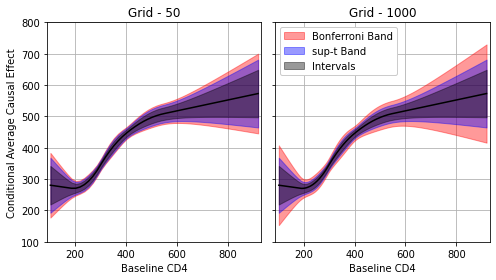

In [33]:
plt.figure(figsize=[7, 4])
plt.subplot(121)
plt.grid(True, zorder=1)
plt.fill_between(xvals_50, cb_b_50[:, 0], cb_b_50[:, 1], alpha=0.4, color='red', zorder=2)
plt.fill_between(xvals_50, cb_s_50[:, 0], cb_s_50[:, 1], alpha=0.4, color='blue', zorder=2)
plt.fill_between(xvals_50, ci_50[:, 0], ci_50[:, 1], alpha=0.4, color='black', zorder=2)
plt.plot(xvals_50, y_50, color='k', zorder=3)
plt.ylim([100, 800])
plt.xlim([90, 930])
plt.xlabel("Baseline CD4")
plt.ylabel("Conditional Average Causal Effect")
plt.title("Grid - 50")

plt.subplot(122)
plt.grid(True, zorder=1)
plt.fill_between(xvals_1k, cb_b_1k[:, 0], cb_b_1k[:, 1], alpha=0.4, color='red', zorder=2, label='Bonferroni Band')
plt.fill_between(xvals_1k, cb_s_1k[:, 0], cb_s_1k[:, 1], alpha=0.4, color='blue', zorder=2, label='sup-t Band')
plt.fill_between(xvals_1k, ci_1k[:, 0], ci_1k[:, 1], alpha=0.4, color='black', zorder=2, label='Intervals')
plt.plot(xvals_1k, y_1k, color='k', zorder=3)
plt.ylim([100, 800])
plt.xlim([90, 930])
plt.yticks([100, 200, 300, 400, 500, 600, 700, 800], ['', ]*8)
plt.xlabel("Baseline CD4")
plt.title("Grid - 1000")
plt.legend(loc='upper left', framealpha=1.)

plt.tight_layout()